# Import Modules

In [16]:
import torch
import torchvision
import matplotlib.pyplot as plt

from time import time
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

# Dataset

In [2]:
batch_size = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=crop_size, scale=(0.8, 1.0)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(size=crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("../datasets/hidrangea/train/", transform=train_transform)
train_dataloader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

test_set = datasets.ImageFolder("../datasets/hidrangea/test/", transform=test_transform)
test_dataloader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

# Build Model

## Architecture

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.flatten = nn.Flatten()
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=1024, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, 2),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.fc(x)
        
        return x
    
model = Model()

## Loss Function

In [4]:
nll_loss = nn.NLLLoss()
nll_loss

NLLLoss()

## Evaluation Metric

In [5]:
accuracy = Accuracy()
accuracy

Accuracy()

## Optimizer

In [6]:
adamw_optimizer = optim.AdamW(model.parameters(), lr=0.001)
adamw_optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)

## Loop Function

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer, eval_metric):
    print("Train:")
    
    losses = []
    for batch, (feature, label) in enumerate(dataloader):
        # Forwardpropagation
        pred_label = model(feature)
        loss = loss_fn(pred_label, label)
        acc = eval_metric(pred_label, label)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        losses.append(loss)
        
        print(f"Batch-{batch + 1} | Accuracy: {acc:>7f} | Loss: {loss:>7f}")
        
    acc = eval_metric.compute()
    print(f"Accuracy : {acc}")
    print(f"Loss     : {sum(losses) / len(dataloader)}")
    eval_metric.reset()
    
def test_loop(dataloader, model, loss_fn, eval_metric):
    print("\nTest:")
    
    losses = []
    for batch, (feature, label) in enumerate(dataloader):
        # Forwardpropagation
        pred_label = model(feature)
        loss = loss_fn(pred_label, label)
        acc = eval_metric(pred_label, label)
        
        with torch.no_grad():
            loss = loss.item()
            losses.append(loss)
        
        print(f"Batch-{batch + 1} | Accuracy: {acc:>7f} | Loss: {loss:>7f}")
        
    acc = eval_metric.compute()
    print(f"Accuracy : {acc}")
    print(f"Loss     : {sum(losses) / len(dataloader)}")
    eval_metric.reset()

In [8]:
epochs = 20

start = time()
for epoch in range(epochs):
    print(f"EPOCH {epoch + 1}")
    print("=" * 46, end="\n")
    train_loop(train_dataloader, model, nll_loss, adamw_optimizer, accuracy)
    test_loop(test_dataloader, model, nll_loss, accuracy)
    print("=" * 46, end="\n\n")
torch.save(model.state_dict(), "../pretrained_model/hidrangea.pth")
stop = time()

total_time = stop - start
print(f"Training time: {(total_time / 60):.3f} minutes")

EPOCH 1
Train:
Batch-1 | Accuracy: 0.562500 | Loss: 0.689094
Batch-2 | Accuracy: 0.507812 | Loss: 0.696933
Batch-3 | Accuracy: 0.546875 | Loss: 0.683457
Batch-4 | Accuracy: 0.453125 | Loss: 0.700474
Batch-5 | Accuracy: 0.460938 | Loss: 0.693890
Batch-6 | Accuracy: 0.687500 | Loss: 0.687893
Batch-7 | Accuracy: 0.648438 | Loss: 0.686598
Batch-8 | Accuracy: 0.759615 | Loss: 0.680961
Accuracy : 0.5740000009536743
Loss     : 0.6899124309420586

Test:
Batch-1 | Accuracy: 0.664062 | Loss: 0.678628
Batch-2 | Accuracy: 0.687500 | Loss: 0.677710
Batch-3 | Accuracy: 0.734375 | Loss: 0.670180
Batch-4 | Accuracy: 0.750000 | Loss: 0.668829
Accuracy : 0.6974999904632568
Loss     : 0.6738368719816208

EPOCH 2
Train:
Batch-1 | Accuracy: 0.734375 | Loss: 0.673383
Batch-2 | Accuracy: 0.625000 | Loss: 0.672035
Batch-3 | Accuracy: 0.578125 | Loss: 0.670143
Batch-4 | Accuracy: 0.765625 | Loss: 0.648721
Batch-5 | Accuracy: 0.632812 | Loss: 0.656857
Batch-6 | Accuracy: 0.726562 | Loss: 0.629801
Batch-7 | Accu

Batch-7 | Accuracy: 0.796875 | Loss: 0.431451
Batch-8 | Accuracy: 0.884615 | Loss: 0.315559
Accuracy : 0.8050000071525574
Loss     : 0.4231906272470951

Test:
Batch-1 | Accuracy: 0.882812 | Loss: 0.370682
Batch-2 | Accuracy: 0.820312 | Loss: 0.408959
Batch-3 | Accuracy: 0.812500 | Loss: 0.379615
Batch-4 | Accuracy: 0.687500 | Loss: 0.589953
Accuracy : 0.8324999809265137
Loss     : 0.4373020976781845

EPOCH 12
Train:
Batch-1 | Accuracy: 0.835938 | Loss: 0.397604
Batch-2 | Accuracy: 0.875000 | Loss: 0.325459
Batch-3 | Accuracy: 0.835938 | Loss: 0.385604
Batch-4 | Accuracy: 0.789062 | Loss: 0.434055
Batch-5 | Accuracy: 0.765625 | Loss: 0.427221
Batch-6 | Accuracy: 0.812500 | Loss: 0.415586
Batch-7 | Accuracy: 0.828125 | Loss: 0.391002
Batch-8 | Accuracy: 0.817308 | Loss: 0.378058
Accuracy : 0.8199999928474426
Loss     : 0.39432357996702194

Test:
Batch-1 | Accuracy: 0.828125 | Loss: 0.389997
Batch-2 | Accuracy: 0.851562 | Loss: 0.337058
Batch-3 | Accuracy: 0.828125 | Loss: 0.402579
Batch-

# Prediction

In [39]:
features, labels = next(iter(test_dataloader))

with torch.no_grad():
    model.eval()
    output = model(features)
    preds = output.argmax(dim=1)
    
preds

tensor([1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 1])

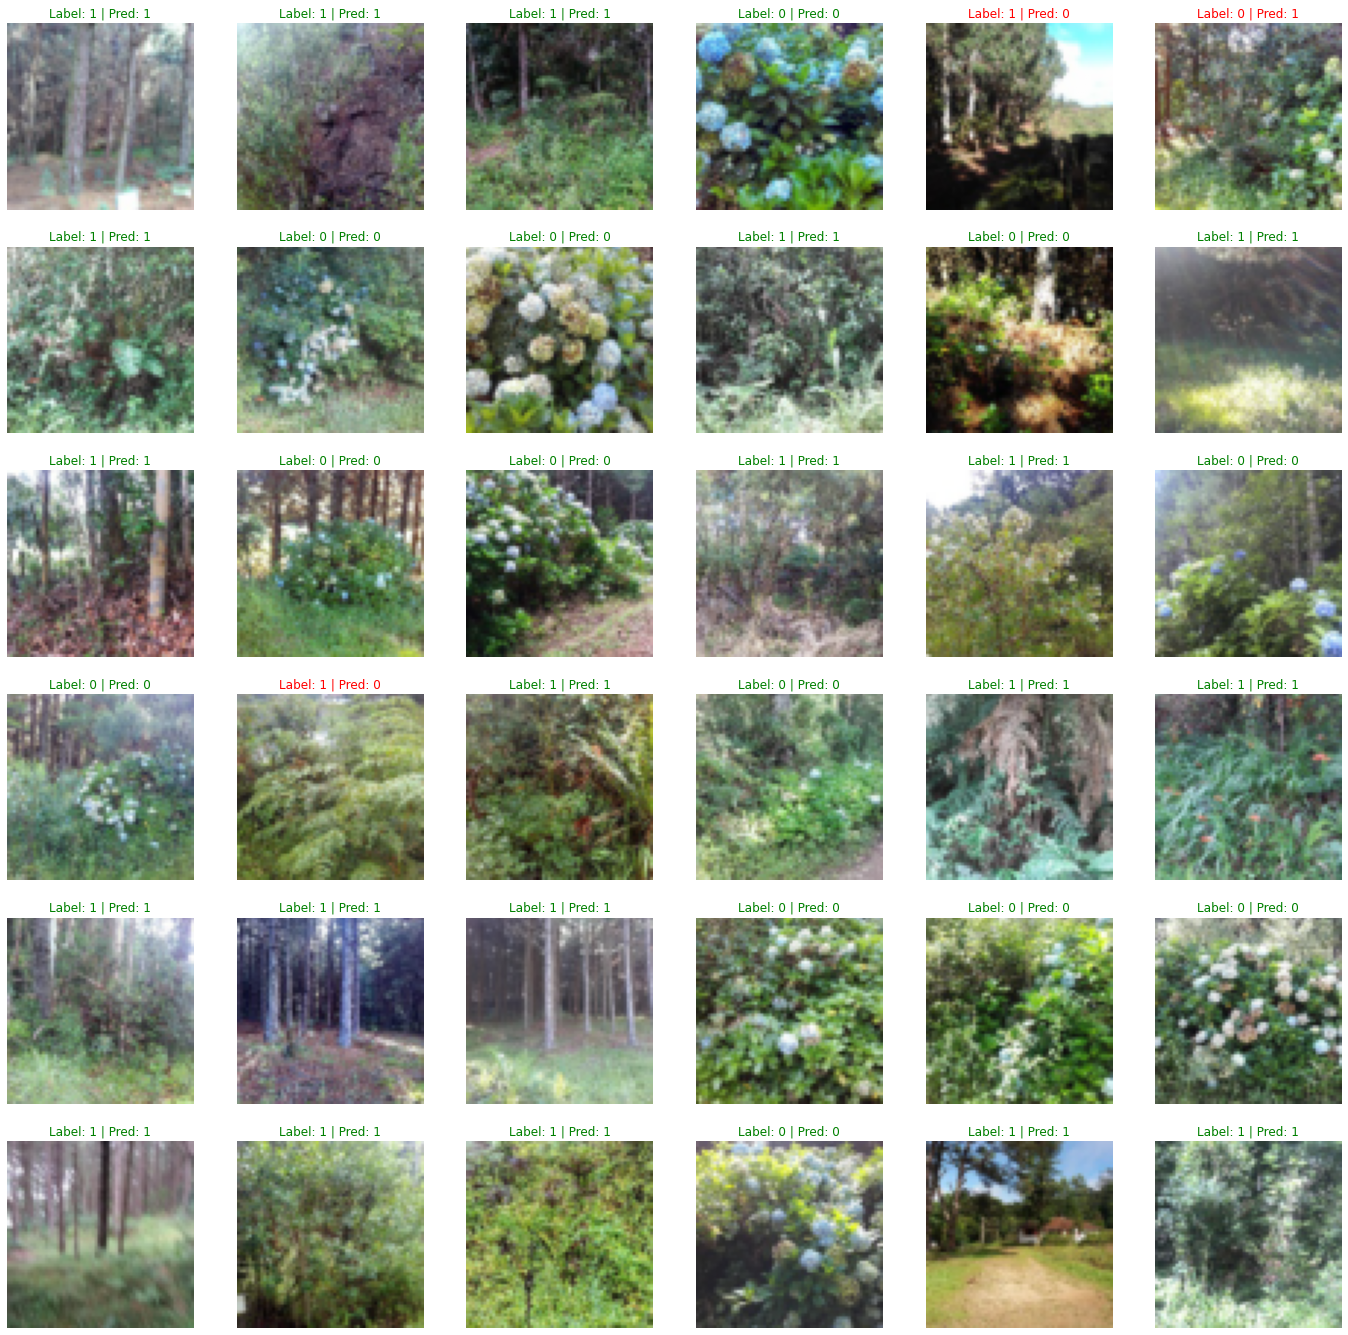

In [42]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))

for image, label, pred, ax in zip(features, labels, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": "red"} if label != pred else {"color": "green"}
    ax.set_title(f"Label: {label} | Pred: {pred}",
                 fontdict=font)
    ax.axis("off")